In [15]:
import tensorflow as tf
import numpy as np
import joblib
import os.path
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import scipy
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Imported the neccessary libaries along with Conv2D to classify images, where it creates the sequential API Keras to create the model and ImageDataGenerator
#to proprocess and augment the images. Here the opetimizer we used is Adam and categorical_crossentropy is for loss function. 

In [16]:
!pip install  nilearn
!pip install  nibabel
!pip install  deepbrain
!pip install  dipy
!pip install  nilearn
!pip install  nipype
!pip install  simpleitk

In [17]:
import os 
os.chdir(os.path.dirname(os.path.abspath('preprocessing.ipynb')))


# os.getcwd()
dirName = os.path.dirname(os.path.dirname(os.path.abspath('../preprocessing.ipynb')) + "/ADNI/")

os.path.isdir(dirName)

root_dir = os.path.dirname(os.path.dirname(os.path.abspath('../preprocessing.ipynb')) + "/MSC_Project")

#Created the directories for the main working folders. 

In [18]:
dirName

'/home/divya/work/msc_project/ADNI'

In [19]:
import pandas as pd

df = pd.read_csv('./../adn_data.csv')
df

#Got the data from the csv file and store it in a dataframe.

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I66824,136_S_1227,MCI,F,65,bl,MRI,MPR; ; N3; Scaled,Processed,2/21/2007,NiFTI,NaN
1,I119735,136_S_0579,MCI,F,66,bl,MRI,MPR-R; ; N3; Scaled_2,Processed,7/10/2006,NiFTI,NaN
2,I40404,136_S_0579,MCI,F,66,bl,MRI,MPR-R; ; N3; Scaled,Processed,7/10/2006,NiFTI,NaN
3,I119733,136_S_0429,MCI,M,63,bl,MRI,MPR; ; N3; Scaled_2,Processed,6/27/2006,NiFTI,NaN
4,I40392,136_S_0429,MCI,M,63,bl,MRI,MPR; ; N3; Scaled,Processed,6/27/2006,NiFTI,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
194,I118668,002_S_0729,MCI,F,65,bl,MRI,MPR; ; N3; Scaled_2,Processed,8/02/2006,NiFTI,NaN
195,I45126,002_S_0559,CN,M,79,bl,MRI,MPR; ; N3; Scaled,Processed,6/27/2006,NiFTI,NaN
196,I118679,002_S_0559,CN,M,79,bl,MRI,MPR; ; N3; Scaled_2,Processed,6/27/2006,NiFTI,NaN
197,I118675,002_S_0413,CN,F,76,bl,MRI,MPR; ; N3; Scaled_2,Processed,5/19/2006,NiFTI,NaN


In [20]:
def get_nii_files(filename, result):
    # print(os.path.isdir(filename), filename)
    if filename.endswith('.nii'):
        result.append(filename)
    elif os.path.isdir(filename):
        # print(filename)
        for file in os.listdir(filename):
            get_nii_files(filename + "/" + file, result)
    
    #Getting the NIFTI files which ends with .nii

In [21]:
import os
import shutil

basedir = root_dir + "/MRI_Group/"

# define the mapping between group information and target folder paths
mapping = {
    'MCI': basedir + '/MCI',
    'CN': basedir + '/CN',
    'AD': basedir + '/AD',
    
}

# loop through the NIFTI files and move them to the target folder paths
nifti_dir = dirName
for filename in os.listdir(nifti_dir):
    result = []
    get_nii_files(dirName + "/" + filename, result)
    # print(result)
    # extract the group information from the file name or metadata
    group_info = df[df['Subject'] == filename]['Group'].values
    
    # print(mapping.get(group_info))
    # create the target folder path based on the mapping
    target_path = mapping.get(group_info[0])
    if target_path is not None:
        # move the file to the target folder path
        for file in result:
            source_path = os.path.join(nifti_dir, file)
            shutil.move(source_path, target_path)


In [22]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [23]:
from nipype.interfaces.ants.segmentation import N4BiasFieldCorrection
from dipy.segment.tissue import TissueClassifierHMRF
from dipy.io.image import load_nifti_data
from __future__ import print_function
from deepbrain import Extractor
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib
# import tensorflow.compat.v1 as tf

import time
import os
import sys
import subprocess
import shutil
import numpy as np


class Preprocess:
  '''

  This is a class to perform preprocessing on an input 3D image.
  
  Parameters of member functions :
       src_path : The source path where the MRI image in .nii extension is present.
       dst_path : The destination path where you would like to save the output of the function. Remember, this will also be the source path for the next preprocess.
    
  '''

  def __init__(self):
    '''
     This is is constructor for Preprocess class  
    '''
    
    print('Start preprocessing....')

  def strip_the_skull(self,src_path,dst_path):
    """
    
    The function is to strip the skull from the input MRI brain image.
    
    Variables & its function:
      img => Loads the data from 3D input file which is then later converted to numpy array using get_fdata()
      affine => Stores the affine data of the input file
      ext => Creates an instance of class extractor
      prob => Set of probabilities are calculated and stored
      mask => The region of brain is identified using threshold 0.5
      brain => Unwanted pixels are made to 0 and is converted back to a nifti image using NiftiImage function. It is then saved as 3D using nibabel library
    
    """
    img = nib.load(src_path)
    affine = img.affine
    img = img.get_fdata()
    ext = Extractor()
    prob = ext.run(img)
    mask = prob > 0.5
    brain = img[:]
    brain[~mask] = 0
    brain = nib.Nifti1Image(brain, affine)
    nib.save(brain, dst_path)

  def __add_pad(self,image, new_height=256, new_width=256):
    """
    
    This private function is used to add padding to the final image, so that all the output images in the preprocessing phase has uniform dimension.
    
    """
    height, width = image.shape
    final_image = np.zeros((new_height, new_width))
    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    #print(final_image.shape,'<--Shape of final image')
    return final_image

    
  def get_noiseless_image(self,src_path,dst_path):
    """
    
    The function is to perform bias correction and produce uniformity throughout the input 3D image. It is performed using SimpleITK library
    
    Variables & its function:
    inputImage => Read and input image from source path
    img_data => Type Cast the pixels of the image
    img_mask => The regions of non-uniform intensity is identified
    corrected_img => N4 Bias Field correction is run and returned back to destination using WriteImage inbuilt function.
    
    """
    try:
      inputImage = sitk.ReadImage(src_path)
      img_data=sitk.Cast(inputImage,sitk.sitkFloat32) 
      img_mask=sitk.BinaryNot(sitk.BinaryThreshold(img_data, 0, 0))
      corrected_img = sitk.N4BiasFieldCorrection(inputImage, img_mask)
      sitk.WriteImage(corrected_img, dst_path)
      print('Succesfully performed N4 Bias Correction')
    
    except RuntimeError:
      #Runs if any stmts of Bias Correction fails
      print('Failed on :' + src_path)  
  
  def do_segmentation(self,src_path,dst_path):
    """
    
    This function is used to segment the input image into a segmented image based on grey matter, white matter and csf. These are the features used to
    detect the stage of AD 

    Variables & its function:
    nclass => value is initialized as 3 inorder to divide to 3 classes-GM,WM,CSF
    beta => The smoothness factor of segmentation
    t0 => Stores the time before segmentation
    hmrf => Create an instance of class TissueClassifierHMRF
    t1 => Store the time after segmentation
    total_time => Calculate the total time taken for segmentation
    brain => Reconstructing the segmented brain image as a 3D file which is then saved to the destination

    """
    #To get only the image data array
    t1 = load_nifti_data(src_path)
    print('t1.shape (%d, %d, %d)' % t1.shape)
    #To load the entire nifti file
    t2 = nib.load(src_path)
    nclass = 3
    beta = 0.1
    t0 = time.time()
    hmrf = TissueClassifierHMRF()
    #Perform segmentation
    initial_segmentation, final_segmentation, PVE = hmrf.classify(t1, nclass, beta)
    t1 = time.time()
    total_time = t1-t0
    print('Total time:' + str(total_time))
    print(final_segmentation.shape)
    brain = nib.Nifti1Image(final_segmentation,t2.affine)
    print('Segmentation performed successfully')
    nib.save(brain, os.path.join(dst_path))
  
  def return_2D_image(self,src_path,dst_path):
    """
    
    This function is used to extract 2D image from the segmented 3D image using matplotlib. Here the images are saved with random number names in 
    grayscale format. 
    
    The images are 3D array of shape (182, 218, 182)
    Choose the dimension : 0 (sagittal), 1 (coronnal) or 2 (axial)
    Choose the slice (between 0 and 182 or 218)
    
    """
    image_1 = nib.load(src_path).get_fdata()
    plt.figure(figsize=(20, 5))
    print('Shape of the MRI : {}'.format(image_1.shape))
    val = [0,1,2]
    for i in val:
      plt.subplot(131)
      plt.axis('off')
      plt.style.use('grayscale')
      final_image = self.__add_pad(np.take(image_1,100,i))
      plt.imshow(final_image)
      get_file_name = src_path.split('/')[-1][0:-4]
      img_name = get_file_name + str(np.random.random_integers(350))+'.png'
      
      folder_path = ""
      if i == 0:
        folder_path = os.path.join(dst_path,'sagittal') #top to bottom
        # Create folder if doesn't exist
        if not os.path.exists(folder_path):
          os.makedirs(folder_path)
      elif i == 1:
        folder_path = os.path.join(dst_path,'coronal') #Front and back
        
        if not os.path.exists(folder_path):
          os.makedirs(folder_path)
      else:
        folder_path = os.path.join(dst_path,'axial') # left to right 
        
        if not os.path.exists(folder_path):
          os.makedirs(folder_path)

      plt.savefig(os.path.join(folder_path,img_name),orientation = 'portrait',transparent = True, bbox_inches = 'tight',pad_inches=0)

In [24]:
basedir = root_dir + "/MRI_Group"

mapping = {
    # 'MCI': basedir + '/MCI/',
    # 'CN': basedir + '/CN/',
    # 'AD': basedir + '/AD/',
    
}

for idx, path in enumerate(mapping):
    for filename in os.listdir(mapping[path]):
        initial_path = mapping[path] + filename
        path_to_store_stripped_skull = root_dir + "/Processed_MRI/skull_strip/" + path + "/" + filename
        path_to_store_bias_corrected = root_dir + "/Processed_MRI/bias_correction/" + path + "/" + filename
        path_to_store_segmented_img = root_dir + "/Processed_MRI/segmented_image/" + path + "/" + filename
        destination_path = root_dir + "/Processed_MRI/processed/" + path
        
        #iterates through each path in a "mapping" dictionary and each file in the directory specified by the path.
        
        input_image = Preprocess()
        input_image.strip_the_skull(initial_path,path_to_store_stripped_skull)
        input_image.get_noiseless_image(path_to_store_stripped_skull,path_to_store_bias_corrected)
        input_image.do_segmentation(path_to_store_bias_corrected,path_to_store_segmented_img)
        input_image.return_2D_image(path_to_store_segmented_img,destination_path)
        
        print('Completed processing for : ' + filename)
        
        #Here we did preprocessing using the "Preprocess" class and saves the resulting images to specific file paths.

# Augmentation


In [25]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
import numpy as np
import os

# load the input image, convert it to a NumPy array, and then
# reshape it to have an extra dimension
# print("[INFO] loading example image...")


main_path = destination_path
adni_list = os.listdir(main_path)
basedir = root_dir + "/Processed_MRI/augmented"

mapping = {
    'MCI': basedir + '/MCI/',
    'CN': basedir + '/CN/',
    'AD': basedir + '/AD/',
    
}

mapping_image_type = {
  0: "sagittal",
  1: "coronal",
  2: "axial"
}

val = [0,1,2]

for idx, path in enumerate(mapping):
    for i in val:
      main_path = root_dir + "/Processed_MRI/processed/" + path + "/" + mapping_image_type[i]
      adni_list = os.listdir(main_path)
      for infile in adni_list:
        print('Next image...',infile)
        image = load_img(os.path.join(main_path+'/'+infile))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        
        # construct the image generator for data augmentation then
        # initialize the total number of images generated thus far
        
        aug = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            zoom_range=0.05,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.05,
            horizontal_flip=True,
            fill_mode="nearest")

        total = 0
        # construct the actual Python generator
        print("[INFO] generating images...")
        
        if i == 0:
          folder_path = root_dir + '/Processed_MRI/augmented/' + path + "/" + mapping_image_type[i]
          # Create folder if doesn't exist
          if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        elif i == 1:
          folder_path = root_dir + '/Processed_MRI/augmented/' + path + "/" + mapping_image_type[i]

          if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        else:
          folder_path = root_dir + '/Processed_MRI/augmented/' + path + "/" + mapping_image_type[i]

        if not os.path.exists(folder_path):
          os.makedirs(folder_path)
        
        imageGen = aug.flow(image,batch_size=1, save_to_dir=folder_path,
        save_prefix="recent_augmented_", save_format="png")
        # loop over examples from our image data augmentation generator
        for image in imageGen:
          # increment our counter
          total += 1
          # if we have reached the specified number of examples, break
          # from the loop
          if total == 10:
            print('This loop done')
            break
          
          #Here we peformed data augemenation to increase the size and variability of the dataset by generating new images that the similar to original ones. 
          #We used the "ImageDataGenerator" class from Keras to perform data augmentation.
          #Also it iterates over the three MRI orientations in a loop to generate 10 augmented images for each of the three MRI image orientations (sagittal, coronal, and axial)

NameError: name 'destination_path' is not defined

# Visualizing the preprocessing steps

# Methods for visualization

In [ ]:
import nibabel as nib
import matplotlib.image as mpimg
import os

def return_2D_image(ad, cn, mci, title):
    # load the image data for each group
    image_ad = nib.load(ad).get_fdata()
    image_cn = nib.load(cn).get_fdata()
    image_mci = nib.load(mci).get_fdata()
    
    # create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
    
    # display each image in a subplot and turn off axis
    ax1.imshow(add_pad(np.take(image_ad,100,0)), cmap='gray')
    ax1.axis('off')
    ax1.set_title('AD')
    
    ax2.imshow(add_pad(np.take(image_cn,100,0)), cmap='gray')
    ax2.axis('off')
    ax2.set_title('CN')
    
    ax3.imshow(add_pad(np.take(image_mci,100,0)), cmap='gray')
    ax3.axis('off')
    ax3.set_title('MCI')
    
    fig.suptitle(title, fontsize=16)
    
    # show the plot
    plt.show()

def visualize_png(axial, coronal, saggital):
  # load the three images
  axial = mpimg.imread(axial)
  coronal = mpimg.imread(coronal)
  saggital = mpimg.imread(saggital)
  
  # create a figure with three subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
  
  # display the images in the subplots and remove axis
  ax1.imshow(axial)
  ax1.axis('off')
  ax2.imshow(coronal)
  ax2.axis('off')
  ax3.imshow(saggital)
  ax3.axis('off')
  
  # set the titles for the subplots
  ax1.set_title('Axial')
  ax2.set_title('Coronal')
  ax3.set_title('Saggital')
  
  # display the figure
  plt.show()

def visualize_augmented(folder):
    # get a list of all image files in the folder
    image_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png') or f.endswith('.jpg')]
    
    # load the first 5 images
    images = [mpimg.imread(f) for f in image_files[:5]]
    
    # create a figure with one row and five columns for the images
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # display each image in a subplot
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')
    
    # show the plot
    plt.show()
    
    
def add_pad(image, new_height=256, new_width=256):
  height, width = image.shape
  final_image = np.zeros((new_height, new_width))
  pad_left = int((new_width - width) / 2)
  pad_top = int((new_height - height) / 2)
  
  # Replace the pixels with the image's pixels
  final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
  #print(final_image.shape,'<--Shape of final image')
  return final_image

# Skull Strip, Bias Correction, Segmentation - Axial

## Skull Strip - AD, CN, MCI

In [ ]:
ad = root_dir + "/code/Processed_MRI/skull_strip/AD/ADNI_002_S_0816_MR_MPR____N3__Scaled_2_Br_20081001115756935_S19532_I118684.nii"
cn = root_dir + "/code/Processed_MRI/skull_strip/CN/ADNI_002_S_0413_MR_MPR____N3__Scaled_2_Br_20081001114937668_S14782_I118675.nii"
mci =root_dir + "/code/Processed_MRI/skull_strip/MCI/ADNI_002_S_0729_MR_MPR____N3__Scaled_2_Br_20081001114302922_S17535_I118668.nii"
return_2D_image(ad, cn, mci, "Skull Strip")

#Here we defined file paths for three skull-stripped MRI images and passes them to a function along with the string.

## Bias Correction - AD, CN, MCI

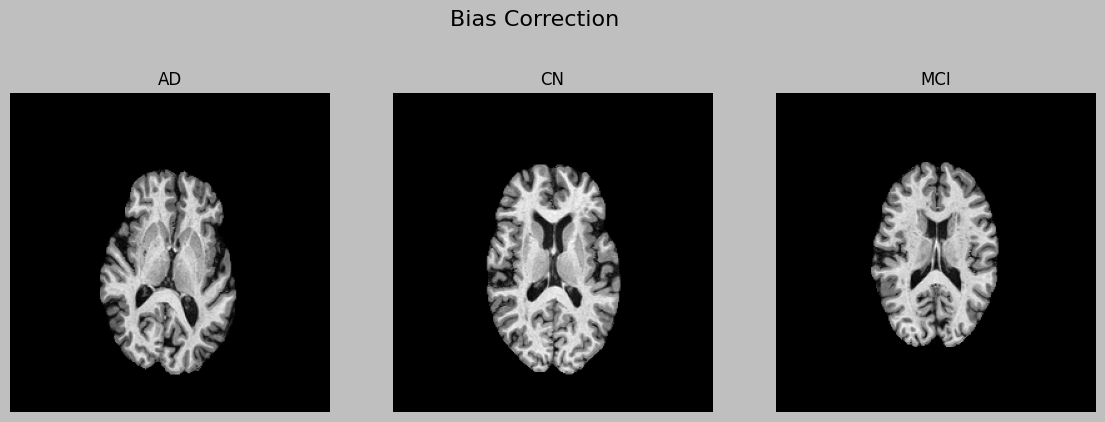

In [ ]:
ad = root_dir + "/code/Processed_MRI/bias_correction/AD/ADNI_002_S_0816_MR_MPR____N3__Scaled_2_Br_20081001115756935_S19532_I118684.nii"
cn = root_dir + "/code/Processed_MRI/bias_correction/CN/ADNI_002_S_0413_MR_MPR____N3__Scaled_2_Br_20081001114937668_S14782_I118675.nii"
mci = root_dir + "/code/Processed_MRI/bias_correction/MCI/ADNI_002_S_0729_MR_MPR____N3__Scaled_2_Br_20081001114302922_S17535_I118668.nii"
return_2D_image(ad, cn, mci, "Bias Correction")

##Here we defined file paths for three Bias-Correction MRI images and passes them to a function along with the string.

## Segmented - AD, CN, MCI

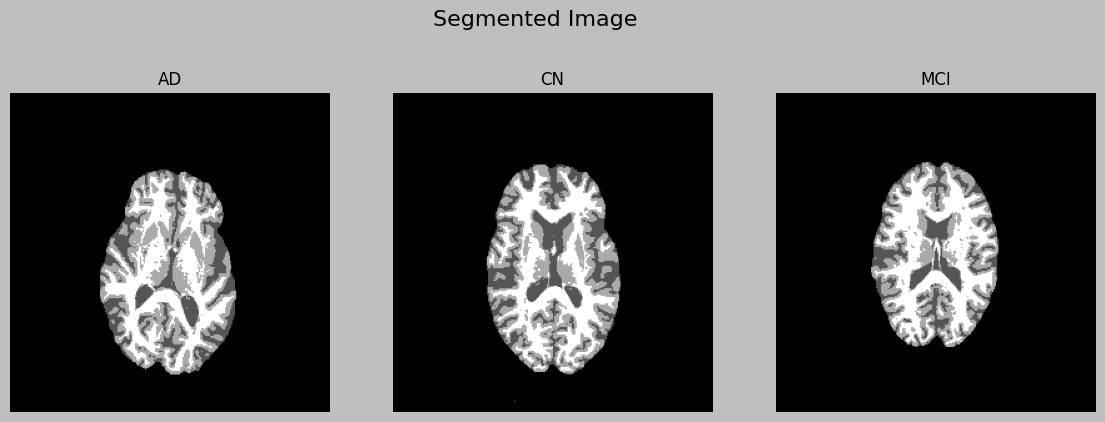

In [ ]:
ad = root_dir + "/code/Processed_MRI/segmented_image/AD/ADNI_002_S_0816_MR_MPR____N3__Scaled_2_Br_20081001115756935_S19532_I118684.nii"
cn = root_dir + "/code/Processed_MRI/segmented_image/CN/ADNI_002_S_0413_MR_MPR____N3__Scaled_2_Br_20081001114937668_S14782_I118675.nii"
mci = root_dir + "/code/Processed_MRI/segmented_image/MCI/ADNI_002_S_0729_MR_MPR____N3__Scaled_2_Br_20081001114302922_S17535_I118668.nii"
return_2D_image(ad, cn, mci, "Segmented Image")

##Here we defined file paths for three Segmented MRI images and passes them to a function along with the string.

# Processed Images

## Final Processed images (AD) - Axial, Coronal and Sagittal

In [ ]:
sagittal = root_dir + "/code/Processed_MRI/processed/AD/sagittal/ADNI_002_S_0816_MR_MPR____N3__Scaled_2_Br_20081001115756935_S19532_I11868460.png"
coronal = root_dir + "/code/Processed_MRI/processed/AD/coronal/ADNI_002_S_0816_MR_MPR____N3__Scaled_2_Br_20081001115756935_S19532_I118684195.png"
axial = root_dir + "/code/Processed_MRI/processed/AD/axial/ADNI_002_S_0816_MR_MPR____N3__Scaled_2_Br_20081001115756935_S19532_I118684224.png"
visualize_png(axial, coronal, sagittal)

#defined file paths for AD class and for three different views of an MRI image, sagittal, coronal, and axial, and then calls a function to visualize those images

## Final Processed images (CN) - Axial, Coronal and Sagittal

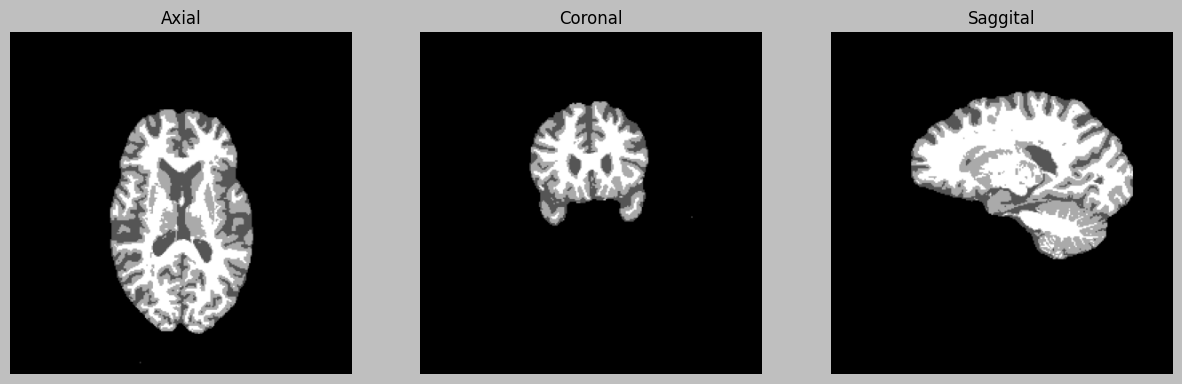

In [ ]:
sagittal = root_dir + "/code/Processed_MRI/processed/CN/sagittal/ADNI_002_S_0413_MR_MPR____N3__Scaled_2_Br_20081001114937668_S14782_I118675155.png"
coronal = root_dir + "/code/Processed_MRI/processed/CN/coronal/ADNI_002_S_0413_MR_MPR____N3__Scaled_2_Br_20081001114937668_S14782_I118675160.png"
axial = root_dir + "/code/Processed_MRI/processed/CN/axial/ADNI_002_S_0413_MR_MPR____N3__Scaled_2_Br_20081001114937668_S14782_I11867536.png"
visualize_png(axial, coronal, sagittal)

##defined file paths for CN class and for three different views of an MRI image, sagittal, coronal, and axial, and then calls a function to visualize those images

## Final Processed images (MCI) - Axial, Coronal and Sagittal

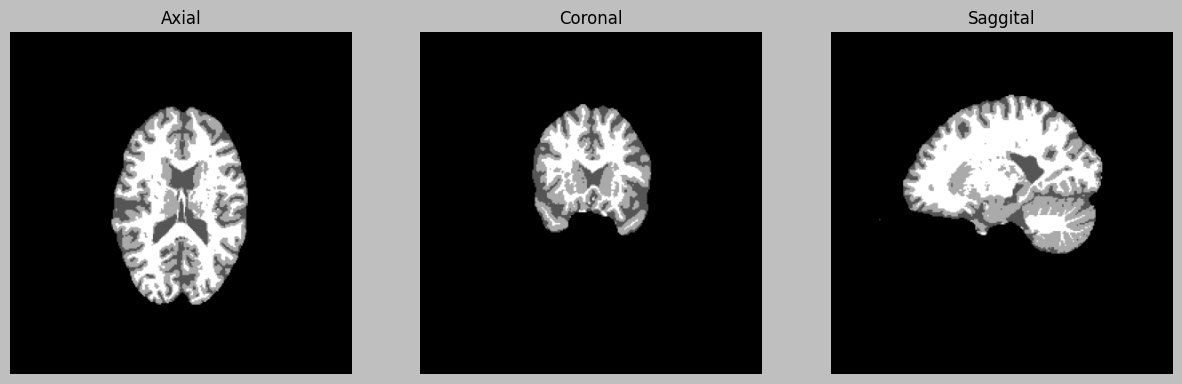

In [ ]:
sagittal = root_dir + "/code/Processed_MRI/processed/MCI/sagittal/ADNI_002_S_0729_MR_MPR____N3__Scaled_2_Br_20081001114302922_S17535_I118668280.png"
coronal = root_dir + "/code/Processed_MRI/processed/MCI/coronal/ADNI_002_S_0729_MR_MPR____N3__Scaled_2_Br_20081001114302922_S17535_I118668178.png"
axial = root_dir + "/code/Processed_MRI/processed/MCI/axial/ADNI_002_S_0729_MR_MPR____N3__Scaled_2_Br_20081001114302922_S17535_I118668116.png"
visualize_png(axial, coronal, sagittal)

##defined file paths for MCI class and for three different views of an MRI image, sagittal, coronal, and axial, and then calls a function to visualize those images

# Augmented Images

## Augmented images (AD) - Axial

In [26]:
visualize_augmented(root_dir + "/code/Processed_MRI/augmented/AD/axial")

#Here we called a function to visualize augmented MRI images for AD in the axial view from a specific directory path

NameError: name 'visualize_augmented' is not defined

## Augmented images (CN) - Axial

In [27]:
visualize_augmented(root_dir + "/code/Processed_MRI/augmented/CN/axial")

#Here we called a function to visualize augmented MRI images for CN in the axial view from a specific directory path

NameError: name 'visualize_augmented' is not defined

## Augmented images (MCI) - Axial

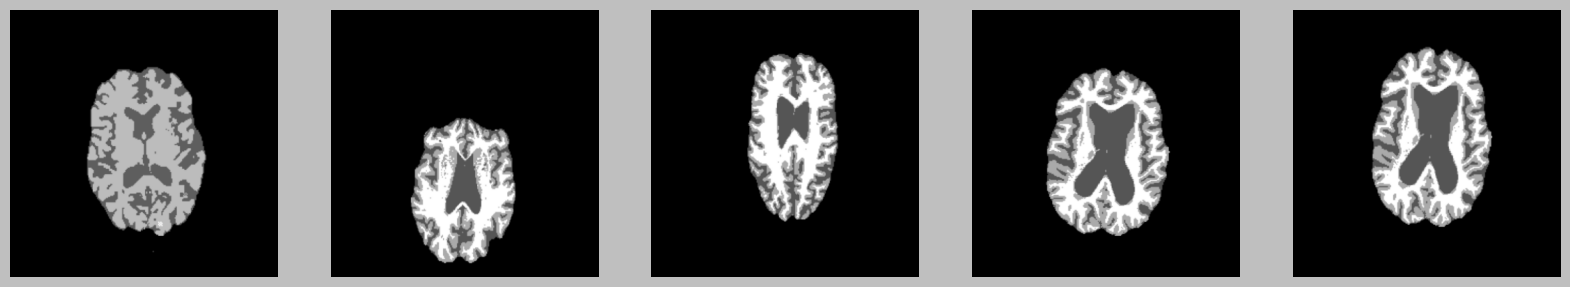

In [ ]:
visualize_augmented(root_dir + "/code/Processed_MRI/augmented/MCI/axial")

#Here we called a function to visualize augmented MRI images for MCI in the axial view from a specific directory path